In [0]:
%pip install "boto3>=1.28" "s3fs>=2023.3.0"


Python interpreter will be restarted.
INFO: pip is looking at multiple versions of fsspec to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of fsspec to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resol

In [0]:

import io
import s3fs
import boto3
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.sql.functions import col, isnan, isnull, when, count, udf, size, split, year, month, format_number, date_format, length
from pyspark.sql.types import IntegerType, DateType, StringType, StructType, DoubleType
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Normalizer, StandardScaler, HashingTF, IDF, Tokenizer, RegexTokenizer

from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation

from pyspark.ml import Pipeline

# Import the evaluation module
from pyspark.ml.evaluation import *
# Import the model tuning module
from pyspark.ml.tuning import *


In [0]:
# To work with Amazon S3 storage, set the following variables using your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
access_key = ''
secret_key = ''
# Set the environment variables so boto3 can pick them up later
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F").replace("+", "%2B")
aws_region = "us-east-2"
# Set this to the name of your bucket where the files are stored
aws_bucket_name = "amazon-reviews-project-dp"
mount_name = "s3dataread"

In [0]:
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key) 

sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key) 

sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

In [0]:
def selecting_featuring (reviews_sdf):
    selected_sdf = reviews_sdf.select(['star_rating', 'total_votes', 'review_body', 'vine', 'product_category', 'verified_purchase', 'helpful_votes', 'clean_review_headline', 'clean_review_body']).sample(False, 0.1, 42)


    # Create a count of the review words
    selected_sdf = selected_sdf.withColumn('review_body_wordcount', size(split(col('review_body'), ' ')))

    selected_sdf = selected_sdf.withColumn("total_votes",selected_sdf.total_votes.cast(DoubleType()))
    selected_sdf = selected_sdf.withColumn("helpful_votes",selected_sdf.total_votes.cast(DoubleType()))
    selected_sdf = selected_sdf.withColumn("review_body_wordcount",selected_sdf.review_body_wordcount.cast(DoubleType()))


        # Filter out short review body texts
        #selected_sdf = selected_sdf.where(length(selected_sdf.clean_review_body) > 10)

        # Filter out review body texts with 5 or fewer words
        #selected_sdf = selected_sdf.where(selected_sdf.review_body_wordcount > 5)

    # Create a label. =1 if over 3, =0 if otherwise
    selected_sdf = selected_sdf.withColumn("label", when(selected_sdf.star_rating >= 4, 1.0).otherwise(0.0) )

    # tokenizer = Tokenizer(inputCol="clean_review_body", outputCol="clean_review_words")
    tokenizer = RegexTokenizer(inputCol="clean_review_body", outputCol="clean_review_words", pattern="\\w+", gaps=False)
    selected_sdf = tokenizer.transform(selected_sdf)

    # Run the hash function over the tokens
    selected_sdf = selected_sdf.drop('clean_review_tf')
    hashtf = HashingTF(numFeatures=2**13, inputCol="clean_review_words", outputCol='clean_review_tf')
    selected_sdf = hashtf.transform(selected_sdf)

    idf = IDF(inputCol='clean_review_tf', outputCol="clean_review_features", minDocFreq=5)
    selected_sdf = idf.fit(selected_sdf).transform(selected_sdf)

    # Create an indexer for the string based columns.
    indexer = StringIndexer(inputCols=["product_category", "vine", "verified_purchase"], outputCols=["product_categoryIndex", "vineIndex", "verified_purchaseIndex"], handleInvalid="keep")

    selected_sdf = indexer.fit(selected_sdf).transform(selected_sdf)

    # Create an encoder for the indexes
    encoder = OneHotEncoder(inputCols=["product_categoryIndex", "vineIndex", "verified_purchaseIndex" ],
                            outputCols=["product_categoryVector", "vineVector", "verified_purchaseVector" ], dropLast=True, handleInvalid="keep")

    selected_sdf = encoder.fit(selected_sdf).transform(selected_sdf)
    return selected_sdf

#def pipeline (sdf):


In [0]:
# Amazon Product Reviews
# Path to Amazon S3 files
filepath = "s3://amazon-reviews-project-dp/raw/"
out_filepath = "s3://amazon-reviews-project-dp/trusted/"

# List of data files
filename_list = ['cleaned_amazon_reviews_us_Apparel_v1_00.tsv.parquet']

#Read files from the list of files names in the s3 bucket
for filename in filename_list:
    # Read in amazon reviews. Reminder: Tab-separated values files
    print(f"Working on file: {filename}")
    reviews_sdf = spark.read.parquet(f"{filepath}{filename}")
    reviews_sdf.printSchema()
    reviews_sdf.show()
    selected_sdf = selecting_featuring (reviews_sdf)
    #reviews_sdf = pipeline (reviews_sdf)


In [0]:
selected_sdf.select('*').show()

+-----------+-----------+--------------------+----+----------------+-----------------+-------------+---------------------+--------------------+---------------------+-----+--------------------+--------------------+---------------------+---------------------+---------+----------------------+----------------------+-------------+-----------------------+
|star_rating|total_votes|         review_body|vine|product_category|verified_purchase|helpful_votes|clean_review_headline|   clean_review_body|review_body_wordcount|label|  clean_review_words|     clean_review_tf|clean_review_features|product_categoryIndex|vineIndex|verified_purchaseIndex|product_categoryVector|   vineVector|verified_purchaseVector|
+-----------+-----------+--------------------+----+----------------+-----------------+-------------+---------------------+--------------------+---------------------+-----+--------------------+--------------------+---------------------+---------------------+---------+----------------------+------

Out[20]: <AxesSubplot:>

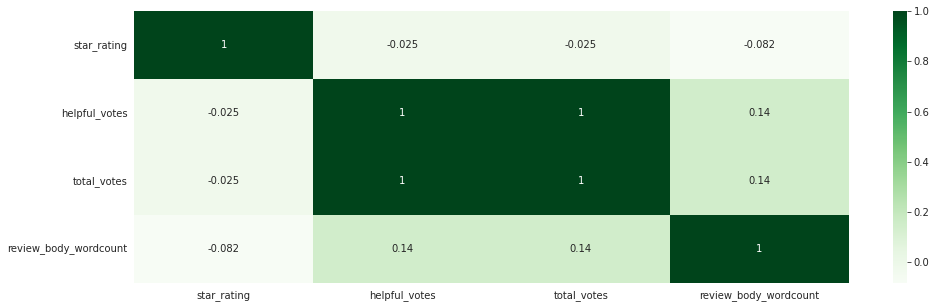

In [0]:
# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Make a list of all of the numeric columns
numeric_columns = [ "star_rating", "helpful_votes", "total_votes", "review_body_wordcount" ]
# Use a vector assembler to combine all of the numeric columns together

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(selected_sdf).select(vector_column)
# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()
# Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns)
sns.set_style("white")
# Crate the plot using Seaborn
plt.figure(figsize=(16,5))
sns.heatmap(correlation_matrix_df,
xticklabels=correlation_matrix_df.columns.values,
yticklabels=correlation_matrix_df.columns.values, cmap="Greens", annot=True)
plt.savefig("correlation_matrix.png")

In [0]:

# Create a few extra columns based on the date
reviews_sdf = reviews_sdf.withColumn("review_date", to_date(reviews_sdf.review_date, 'yyyy-MM-dd'))

reviews_sdf = reviews_sdf.withColumn("review_year", year(col("review_date")))
reviews_sdf = reviews_sdf.withColumn("review_month", month(col("review_date")))
reviews_sdf = reviews_sdf.withColumn("review_yearmonth", date_format(col("review_date"), "yyyy-MM"))   # Like 2023-01   2023-02 etc.
reviews_sdf = reviews_sdf.withColumn("review_dayofweek", date_format(col("review_date"), "E"))         # 'Monday' 'Tuesday' etc.
reviews_sdf = reviews_sdf.withColumn("review_weekend", when(reviews_sdf.review_dayofweek == 'Saturday',1.0).when(reviews_sdf.review_dayofweek == 'Sunday', 1.0).otherwise(0))
reviews_sdf.show()
# Get the number of records
transformed_sdf.count()
# Look at statistics for some specific columns
transformed_sdf.select("clean_review_headline", "clean_review_body", "review_body_wordcount").summary("count", "min", "max").show()

In [0]:
# Use groupby to get a count by date. Then convert to pandas dataframe
summary_sdf = reviews_sdf.where(col("review_year") >= 2000).groupby("review_year").count().sort("review_year")
df = summary_sdf.toPandas()

# Using Pandas built-in plotting functions
# Create a bar plot using the columns order_date and count
myplot = df.plot.bar('review_year','count')
# Set the x-axis and y-axis labels
myplot.set(xlabel='Date', ylabel='Number of Reviews')
# Set the title
myplot.set(title='Number of Reviews by Year')
myplot.figure.set_tight_layout('tight')
# Save the plot as a PNG file
#myplot.get_figure().savefig("order_count_by_date.png")

In [0]:
# Visualize regression results
# Plot label against predicted label (prediction)
import seaborn as sns
# The Spark dataframe test_results holds the original 'label' as well as the 'prediction'
# Select and convert to a Pandas dataframe
df = test_results.select('label', 'prediction').toPandas()
# Set the style for Seaborn plots
sns.set_style("white")
# Create a relationship plot between label and prediction
sns.lmplot(x='label', y='prediction', logistic=True, data=df)

In [0]:
# Use groupby to get a count by date. Then convert to pandas dataframe
summary_sdf = reviews_sdf.where(col("review_year") >= 2000).groupby("review_year").count().sort("review_year")
df = summary_sdf.toPandas()

# Using Pandas built-in plotting functions
# Create a bar plot using the columns order_date and count
myplot = df.plot.bar('review_year','count')
# Set the x-axis and y-axis labels
myplot.set(xlabel='Date', ylabel='Number of Reviews')
# Set the title
myplot.set(title='Number of Reviews by Year')
myplot.figure.set_tight_layout('tight')
# Save the plot as a PNG file
#myplot.get_figure().savefig("order_count_by_date.png")

In [0]:
# Visualize regression results
# Plot label against predicted label (prediction)
import seaborn as sns
# The Spark dataframe test_results holds the original 'label' as well as the 'prediction'
# Select and convert to a Pandas dataframe
df = test_results.select('label', 'prediction').toPandas()
# Set the style for Seaborn plots
sns.set_style("white")
# Create a relationship plot between label and prediction
sns.lmplot(x='label', y='prediction', logistic=True, data=df)

In [0]:
# Working ROC 
import io
import matplotlib.pyplot as plt

img_data = io.BytesIO()

parammap = cv.bestModel.extractParamMap()
for p, v in parammap.items():
    print(p, v)
# Grab the model from Stage 3 of the pipeline
mymodel = cv.bestModel
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'r--')
x = mymodel.summary.roc.select('FPR').collect()
y = mymodel.summary.roc.select('TPR').collect()
plt.scatter(x, y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()
#plt.savefig("reviews_roc.png")
# Write the figure to the buffer
plt.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)
# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://amazon-reviews-project-dp/visualizations/ROC_Modlel_results.png', 'wb') as f:
    f.write(img_data.getbuffer())

In [0]:
# Amazon Product Reviews
# Path to Amazon S3 files
filepath = "s3://amazon-reviews-project-dp/raw/"
out_filepath = "s3://amazon-reviews-project-dp/trusted/"

# List of data files
filename_list = ['trusted_cleaned_amazon_reviews_us_Apparel_v1_00.tsv.parquet']

#Read files from the list of files names in the s3 bucket
for filename in filename_list:
    # Read in amazon reviews. Reminder: Tab-separated values files
    print(f"Working on file: {filename}")
    reviews_sdf = spark.read.parquet(f"{filepath}{filename}")
    reviews_sdf.printSchema()
    reviews_sdf.show()

In [0]:
#transformed_sdf = transformed_sdf.withColumn("review_body_wordcount",transformed_sdf.review_body_wordcount.cast(DoubleType()))
#transformed_sdf = transformed_sdf.withColumn("total_votes",transformed_sdf.total_votes.cast(DoubleType()))

In [0]:
import seaborn as sns
# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Make a list of all of the numeric columns

numeric_columns = [ "product_categoryVector", "vineVector", "verified_purchaseVector", "total_votes", "review_body_wordcount" ]
# Use a vector assembler to combine all of the numeric columns together
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(transformed_sdf).select(vector_column)
# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()
# Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns)
sns.set_style("white")
# Crate the plot using Seaborn
plt.figure(figsize=(16,5))
sns.heatmap(correlation_matrix_df,
xticklabels=correlation_matrix_df.columns.values,
yticklabels=correlation_matrix_df.columns.values, cmap="Greens", annot=True)
plt.savefig("correlation_matrix.png")

In [0]:
### Code 

# Using Pandas built-in plotting functions
# Create a bar plot using the columns order_date and count
x = mymodel.summary.roc.select('FPR').collect()
y = mymodel.summary.roc.select('TPR').collect()
df = transformed_sdf.toPandas() 
import pandas as pd
df = test_results.select('label', 'prediction').toPandas()
myplot = df.plot.bar(x,y)
# Set the x-axis and y-axis labels
myplot.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
# Set the title
myplot.set(title="ROC Curve")
myplot.figure.set_tight_layout('tight')
# Save the plot as a PNG file
#myplot.get_figure().savefig("order_count_by_date.png")